In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Setup complete ✅")


Setup complete ✅


In [2]:
# Load dataset
df = pd.read_csv("../data/weekly_marketing.csv", parse_dates=['week'])
print("Shape:", df.shape)

# Preview first few rows
df.head()


Shape: (104, 12)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


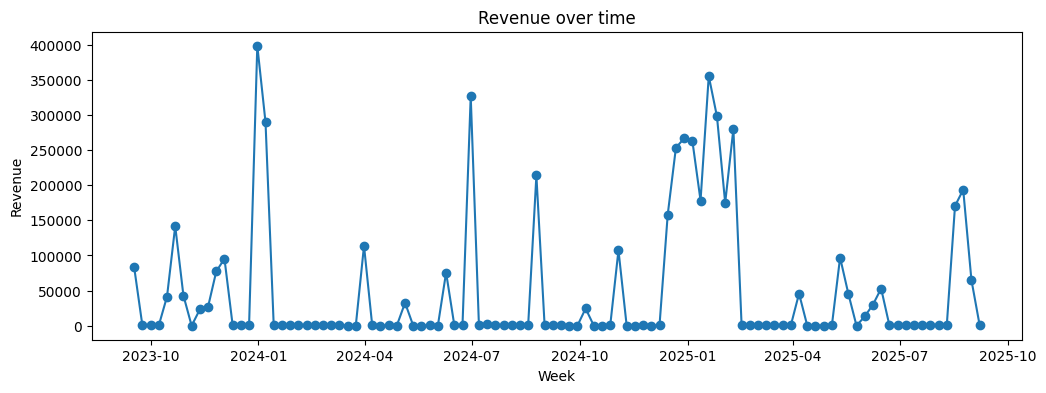

In [3]:
plt.figure(figsize=(12,4))
plt.plot(df['week'], df['revenue'], marker='o')
plt.title("Revenue over time")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.show()


In [4]:
media_channels = ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend','google_spend']

# Create binary "active" flags
for ch in media_channels:
    df[f'{ch}_active'] = (df[ch] > 0).astype(int)

df.head()


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,facebook_spend_active,tiktok_spend_active,instagram_spend_active,snapchat_spend_active,google_spend_active
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,1,1,1,1,1
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,1,0,0,0,1
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,1,0,0,0,0
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,1,0,0,0,0
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,1,0,1,0,0


In [5]:
# Log-transform revenue (helps interpret elasticities)
df['revenue_log'] = np.log1p(df['revenue'])

holdout_weeks = 12
train = df.iloc[:-holdout_weeks].copy()
test  = df.iloc[-holdout_weeks:].copy()

print("Train shape:", train.shape, "Test shape:", test.shape)


Train shape: (92, 18) Test shape: (12, 18)


In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Features: only social spends
X1_cols = ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend']
X1_train = train[X1_cols]
y1_train = np.log1p(train['google_spend'])

alphas = np.logspace(-3, 3, 13)

stage1_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=alphas, cv=TimeSeriesSplit(n_splits=5)))
])

stage1_model.fit(X1_train, y1_train)
print("Best alpha:", stage1_model.named_steps['ridge'].alpha_)


Best alpha: 1000.0


In [7]:
df['google_pred_log'] = stage1_model.predict(df[X1_cols])
df['google_pred'] = np.expm1(df['google_pred_log'])

df[['week','google_spend','google_pred']].head()


,week,google_spend,google_pred
0,2023-09-17,3130.14,40.959132
1,2023-09-24,2704.00,38.562089
2,2023-10-01,0.00,36.787462
3,2023-10-08,0.00,33.543843
4,2023-10-15,0.00,40.603718


In [8]:
from sklearn.linear_model import ElasticNetCV

# Recreate train/test with new google_pred
train = df.iloc[:-holdout_weeks].copy()
test  = df.iloc[-holdout_weeks:].copy()

# Features for stage 2
X2_cols = [
    'google_pred_log',    # mediated effect
    'emails_send',
    'sms_send',
    'average_price',
    'promotions',
    'facebook_spend',     # optional: direct social effect
    'tiktok_spend'
]

X2_train = train[X2_cols]
y2_train = train['revenue_log']

X2_test  = test[X2_cols]
y2_test  = test['revenue_log']

# ElasticNet with cross-validation
enet = ElasticNetCV(
    l1_ratio=[.1, .5, .9], 
    alphas=np.logspace(-3, 1, 20),
    cv=TimeSeriesSplit(n_splits=5),
    random_state=RANDOM_STATE,
    max_iter=5000
)

enet.fit(X2_train, y2_train)

print("Best alpha:", enet.alpha_)
print("Best l1_ratio:", enet.l1_ratio_)


Best alpha: 0.001
Best l1_ratio: 0.9


Stage 2 Test RMSE: 2.3690715936653937
Stage 2 Test MAPE: 0.27469589760056323


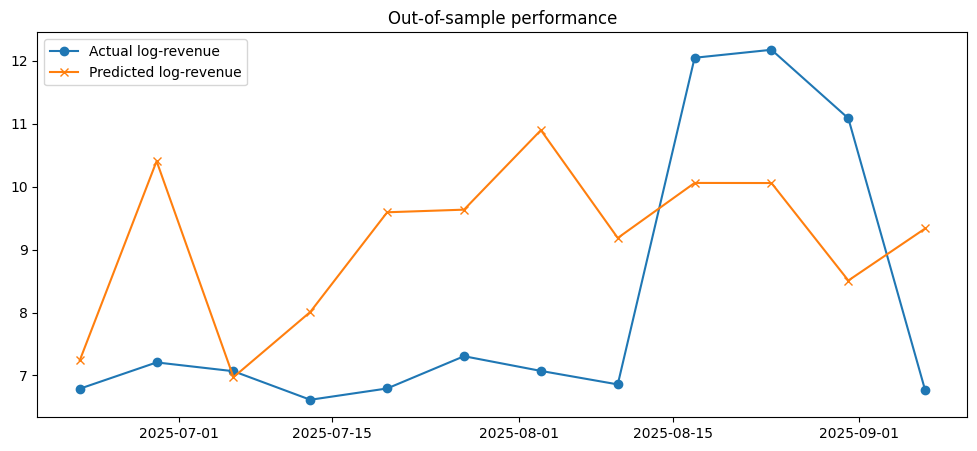

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

y2_pred = enet.predict(X2_test)

rmse = np.sqrt(mean_squared_error(y2_test, y2_pred))
mape = mean_absolute_percentage_error(y2_test, y2_pred)

print("Stage 2 Test RMSE:", rmse)
print("Stage 2 Test MAPE:", mape)

plt.figure(figsize=(12,5))
plt.plot(test['week'], y2_test, marker='o', label="Actual log-revenue")
plt.plot(test['week'], y2_pred, marker='x', label="Predicted log-revenue")
plt.title("Out-of-sample performance")
plt.legend()
plt.show()


In [10]:
coef_series = pd.Series(enet.coef_, index=X2_cols).sort_values(ascending=False)
print("ElasticNet coefficients (log-log space):")
display(coef_series)


ElasticNet coefficients (log-log space):


google_pred_log    28.170794
facebook_spend      0.001963
sms_send            0.000114
emails_send         0.000005
tiktok_spend       -0.000628
average_price      -0.166091
promotions         -0.448303
dtype: float64

In [12]:
# Social → Google (from Stage 1)
social_coefs_stage1 = pd.Series(
    stage1_model.named_steps['ridge'].coef_,
    index=X1_cols
)

# Safely get Google → Revenue effect (0 if dropped)
google_coef = coef_series.get('google_pred_log', 0)

# Indirect effect = (social → Google) * (Google → Revenue)
indirect_effects = social_coefs_stage1 * google_coef

# Direct effects: reindex coef_series on X1_cols (fill missing with 0)
direct_effects = coef_series.reindex(X1_cols).fillna(0)

# Combine into one DataFrame
effect_decomp = pd.DataFrame({
    "direct": direct_effects,
    "indirect_via_google": indirect_effects
})
effect_decomp["total"] = effect_decomp["direct"] + effect_decomp["indirect_via_google"]

display(effect_decomp.sort_values("total", ascending=False))


,direct,indirect_via_google,total
snapchat_spend,0.000000,0.941931,0.941931
instagram_spend,0.000000,0.702742,0.702742
tiktok_spend,-0.000628,0.071829,0.071201
facebook_spend,0.001963,-2.094353,-2.092390


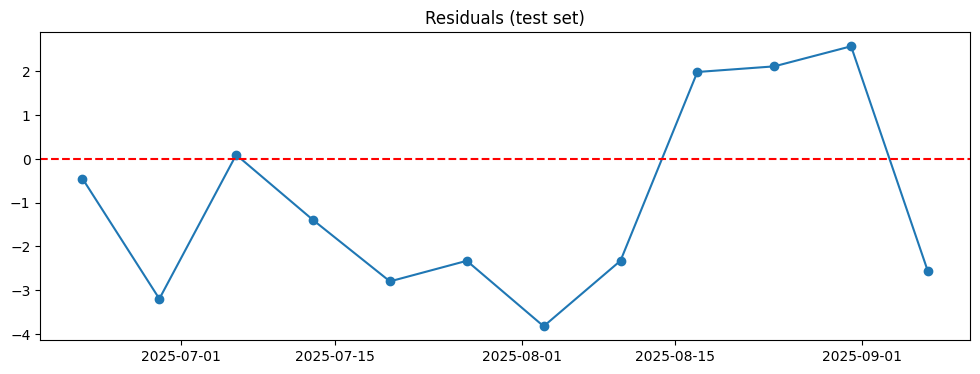

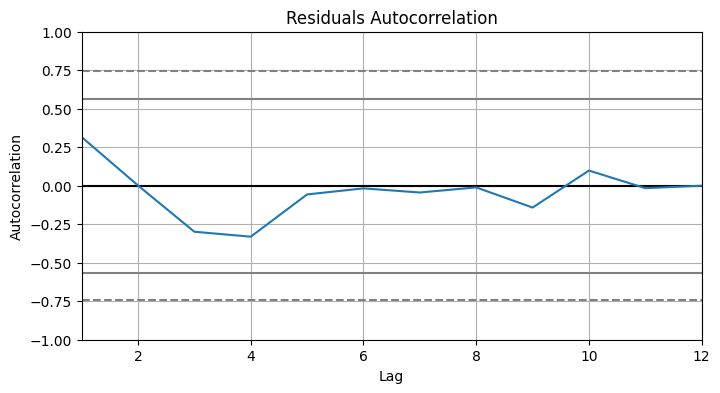

In [15]:
# Residual diagnostics
resid = y2_test - y2_pred

# Plot residuals over time
plt.figure(figsize=(12,4))
plt.plot(test['week'], resid, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (test set)")
plt.show()

# Autocorrelation plot (no statsmodels needed)
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(8,4))
autocorrelation_plot(resid)
plt.title("Residuals Autocorrelation")
plt.show()


In [16]:
# Price sensitivity: +/- 5%
X2_test_copy = X2_test.copy()

X_plus = X2_test_copy.copy()
X_plus['average_price'] *= 1.05
pred_plus = enet.predict(X_plus)

X_minus = X2_test_copy.copy()
X_minus['average_price'] *= 0.95
pred_minus = enet.predict(X_minus)

print("Δ Revenue (log-space) with +5% price:", pred_plus.mean() - y2_pred.mean())
print("Δ Revenue (log-space) with -5% price:", pred_minus.mean() - y2_pred.mean())

# Promotions toggle (if binary)
if 'promotions' in X2_test.columns:
    X_promo_on = X2_test_copy.copy()
    X_promo_on['promotions'] = 1
    pred_promo_on = enet.predict(X_promo_on)

    X_promo_off = X2_test_copy.copy()
    X_promo_off['promotions'] = 0
    pred_promo_off = enet.predict(X_promo_off)

    print("Δ Revenue with promotions ON vs OFF:",
          pred_promo_on.mean() - pred_promo_off.mean())


Δ Revenue (log-space) with +5% price: -0.7770993092090812
Δ Revenue (log-space) with -5% price: 0.7770993092090848
Δ Revenue with promotions ON vs OFF: -0.4483032322389704


In [18]:
from sklearn.metrics import mean_squared_error

def rolling_cv_eval(X, y, initial_train_size=52, horizon=12):
    """Expanding window CV to check stability over time."""
    rmse_list = []
    coef_list = []
    n = len(X)
    i = initial_train_size
    while i + horizon <= n:
        X_tr, y_tr = X.iloc[:i], y.iloc[:i]
        X_val, y_val = X.iloc[i:i+horizon], y.iloc[i:i+horizon]
        
        model = ElasticNetCV(
            l1_ratio=[.1, .5, .9],
            alphas=np.logspace(-3, 1, 20),
            cv=TimeSeriesSplit(n_splits=3),
            random_state=RANDOM_STATE,
            max_iter=5000
        )
        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)
        
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred_val)))
        coef_list.append(pd.Series(model.coef_, index=X.columns))
        
        i += horizon
    
    return rmse_list, coef_list

# ✅ FIX: use pd.concat instead of .append
X_all = pd.concat([X2_train, X2_test])
y_all = pd.concat([y2_train, y2_test])

rmse_list, coef_list = rolling_cv_eval(X_all, y_all)

print("Rolling RMSEs:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))


Rolling RMSEs: [np.float64(3.6573433036897214), np.float64(2.665648000148562), np.float64(2.1605758311357643), np.float64(3.0744496062977316)]
Mean RMSE: 2.889504185317945


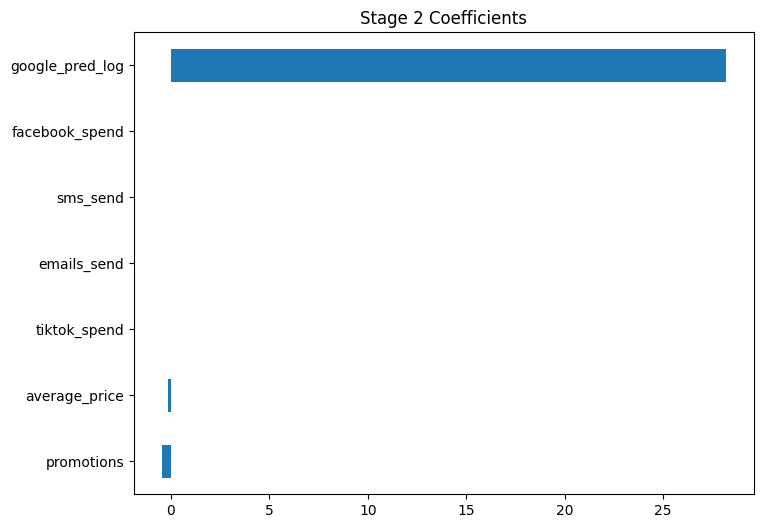

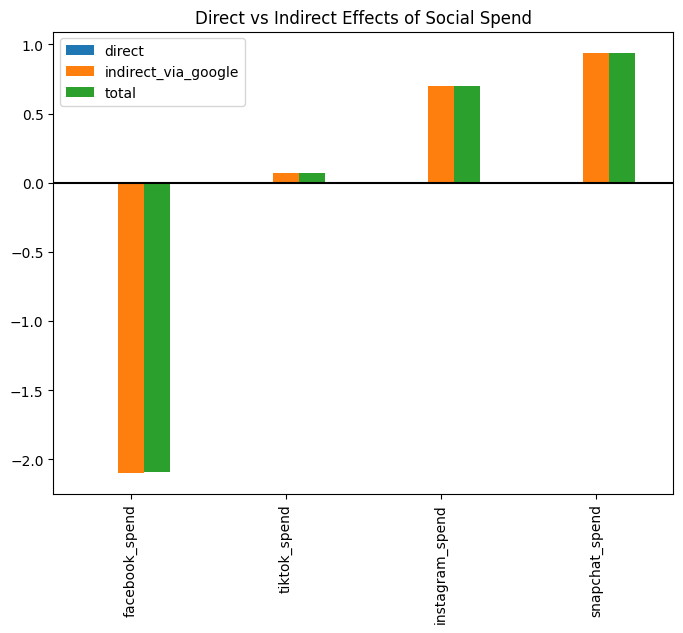

In [19]:
# Coefficient importance
coef_series.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Stage 2 Coefficients")
plt.show()

# Direct vs indirect barplot
effect_decomp.plot(kind='bar', figsize=(8,6))
plt.title("Direct vs Indirect Effects of Social Spend")
plt.axhline(0, color='black')
plt.show()
